# Transmon Floquet analysis

In this initial demo we perform the Floquet analysis on a transmon with a readout frequency above the qubit frequency, mapping the probability of ionization as a function of drive strength and drive frequency. We then compare these simulations to Blais-style branch crossing plots, which identify the states the qubit states leak to.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import scqubits as scq
from cycler import cycler

import floquet as ft


color_cycler = cycler(plt.rcParams["axes.prop_cycle"])
ls_cycler = cycler(ls=["-", "--", "-.", ":"])
alpha_cycler = cycler(alpha=[1.0, 0.6, 0.2])
color_ls_alpha_cycler = alpha_cycler * ls_cycler * color_cycler

## Transmon with readout resonator above the qubit frequency

In [2]:
filepath = ft.generate_file_path("h5py", "transmon_floquet", "out")

# Transmon parameters
num_states = 20
# These parameters give a transmon with E10 = 5.45 GHz, alpha = -219 MHz
qubit_params = {"EJ": 20.0, "EC": 0.2, "ng": 0.25, "ncut": 41}
tmon = scq.Transmon(**qubit_params, truncated_dim=num_states)
state_indices = [0, 1]  # get data for ground and first excited states


# Express operators in eigenbasis of transmon
def get_H0_H1(qubit_instance: scq.GenericQubit) -> tuple[qt.Qobj, qt.Qobj]:
    hilbert_space = scq.HilbertSpace([qubit_instance])
    hilbert_space.generate_lookup()
    evals = hilbert_space["evals"][0][0:num_states]
    H0 = 2.0 * np.pi * qt.Qobj(np.diag(evals - evals[0]))
    H1 = hilbert_space.op_in_dressed_eigenbasis(qubit_instance.n_operator)
    return H0, H1


H0, H1 = get_H0_H1(tmon)

# Drive parameters
# Drive frequencies to scan over
omega_d_values = 2.0 * np.pi * np.linspace(7.5, 10.0, 120)
# Induced ac stark shifts to scan over
chi_ac_values = 2.0 * np.pi * np.linspace(0.0, 0.1, 59)
# To achieve same range of chi_ac for the various drive frequencies, need different
# drive amplitudes. This utility computes the linear drive strength required to achieve
# a desired induced ac-Stark shift for the various drive frequencies.
chi_to_amp = ft.ChiacToAmp(H0, H1, state_indices, omega_d_values)
# drive_amplitudes has shape (a,w), where a is amplitude and w is frequency
drive_amplitudes = chi_to_amp.amplitudes_for_omega_d(chi_ac_values)

# initialize the model to pass to FloquetAnalysis
model = ft.Model(
    H0, H1, omega_d_values=omega_d_values, drive_amplitudes=drive_amplitudes
)

options = ft.Options(
    fit_range_fraction=0.5,  # split the fit into segments based on this fraction
    floquet_sampling_time_fraction=0.0,  # fraction of the period to compute the Floquet modes  # noqa E501
    fit_cutoff=4,  # polynomial cutoff
    overlap_cutoff=0.8,  # cutoff for excluding from the fit
    nsteps=30_000,  # qutip integration parameter
    num_cpus=6,  # number of cpus to use to compute Floquet modes in parallel
    save_floquet_modes=True,  # whether or not to save floquet modes themselves
)

 /opt/homebrew/Caskroom/miniconda/base/envs/floquet/lib/python3.11/site-packages/scqubits/utils/spectrum_utils.py: 199RuntimeWarning: overflow encountered in matmul
 /opt/homebrew/Caskroom/miniconda/base/envs/floquet/lib/python3.11/site-packages/scqubits/utils/spectrum_utils.py: 199RuntimeWarning: invalid value encountered in matmul
 /opt/homebrew/Caskroom/miniconda/base/envs/floquet/lib/python3.11/site-packages/scqubits/utils/spectrum_utils.py: 199

In [3]:
floquet_analysis = ft.FloquetAnalysis(
    model, state_indices=state_indices, options=options
)
data_vals = floquet_analysis.run(filepath=filepath)

Running floquet simulation with parameters: 
model: H0: Quantum object: dims=[[20], [20]], shape=(20, 20), type='oper', dtype=Dense, isherm=True
Qobj data =
[[  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.          34.23724704   0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.          67.09785619   0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.          98.47961089   0.
    0.           0.           0.           0.    

## Plot the probability of nonlinear transitions

We compute this probability for transmon states $|0\rangle$ and $|1\rangle$ (specified by `state_indices`) by comparing the Floquet modes to a fitted "ideal displaced state," chosen to be a polynomial in drive frequency and amplitude (the maximum degree of this polynomial is specified by `fit_cutoff`). The displaced state is itself computed using the Floquet modes, but excluding those modes where overlap with the reference state (for instance the undriven eigenstate) is below a cutoff value (specified by `overlap_cutoff`), possibly indicating a resonance.

In this example we perform the fit iteratively, which is necessary to explore strong drive amplitudes (where overlap with the bare eigenstate would fall below the cutoff regardless of a resonance, due to normal ac-Stark shift effects). We split the drive amplitudes into two ranges (here specified by `fit_range_fraction`). In the first range, we compare the Floquet modes to the undriven eigenstates. We then fit the ideal displaced state for this range. This fitted state is then used as the reference state for the next range of drive amplitudes.

For more details on the theory, please see [Xiao, Venkatraman et al, arXiv (2023)](https://arxiv.org/abs/2304.13656), specifically appendices I and J.

In [4]:
# All of the data is saved in data_vals above, but we can also recover the data from
# file as shown here.
_, new_data_dict = ft.read_from_file(filepath)

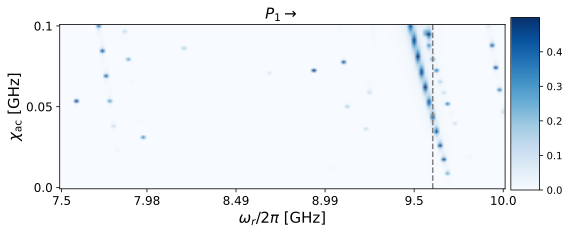

In [5]:
tmon_idx = 1  # Plot leakage probability for |e>. Try 0 for |g>
omega_d_idx = 100  # Drive frequency where we take a linecut

# Clipping the transition probability data at 0.5 gives nice-looking results.
# try plotting "bare_state_overlaps" or "intermediate_state_overlaps" instead of
# "displaced_state_overlaps" to look at the overlaps with the bare state or the
# displaced state obtained from fitting the intermediate amplitude regions,
# respectively. In the bare_state_overlaps results you can clearly see the effects of
# the ac stark shift, causing deviation of the floquet mode from the bare state
# even in the absence of a resonance.
plot_data = np.clip(
    1 - new_data_dict["displaced_state_overlaps"][:, :, tmon_idx].T ** 2, 0.0, 0.5
)
fig, ax = plt.subplots(figsize=(8, 8))
xticks = omega_d_values / (2.0 * np.pi)
yticks = chi_ac_values / (2.0 * np.pi)
num_x_pts = len(xticks)
num_y_pts = len(yticks)
im = plt.imshow(
    plot_data, origin="lower", cmap="Blues", aspect=0.75, interpolation="none"
)
plt.axvline(omega_d_idx, color="grey", ls="--")
ax.set_title(f"$P_{tmon_idx}$" + r"$\rightarrow$", fontsize=15)
xticklabel_locations = np.linspace(0, num_x_pts - 1, 6, dtype=int)
ax.set_xticks(xticklabel_locations)
ax.set_xticklabels(
    np.array(np.around(xticks[xticklabel_locations], decimals=2), dtype=str),
    fontsize=12,
)
yticklabel_locations = np.linspace(0, num_y_pts - 1, 3, dtype=int)
ax.set_yticks(yticklabel_locations)
ax.set_yticklabels(
    np.array(np.around(yticks[yticklabel_locations], decimals=2), dtype=str),
    fontsize=12,
)
ax.set_ylabel(r"$\chi_{\rm ac}$ [GHz]", fontsize=15)
ax.set_xlabel(r"$\omega_r/2\pi$ [GHz]", fontsize=15)
cax = plt.axes([0.91, 0.35, 0.05, 0.3])
cbar = plt.colorbar(im, cax=cax)
plt.show()

This plot gives us a "birds-eye" view of ionization. Anywhere we see white, the Floquet mode agrees with the "ideal displaced state." Anywhere we see blue, those two do not agree and we interpret this as a nonlinear resonance (or "ionization"). At the linecut specified by the grey dashed line, we see that the first excited state goes through two separate resonances.

## Branch analysis

Using the Blais branch analysis, we can identify which states are responsible for the two transitions identified above. In this analysis we track the Floquet modes step-by-step from zero drive amplitude up to the largest drive amplitude we care about. We do this by computing overlaps of the new Floquet modes with those from the previous amplitude step. Thus there is no need to worry about the "ideal displaced state": the states are automatically tracked.

Having tracked and identified the Floquet modes (and associated quasienergies), we compute the average excitation number for each branch $\ell$: $N_{t}(\ell)=\sum_{j}j|\langle j\widetilde{|\ell\rangle}|^2$, where $|j\rangle$ are the undriven eigenstates and $\widetilde{|\ell\rangle}$ is the Floquet mode assigned to branch $\ell$. These Floquet modes are themselves a function of drive amplitude and frequency, leading to the branch plots below.

For more details on the theory, please see [Dumas et al, arXiv (2024)](https://arxiv.org/abs/2402.06615), [Shillito et al, PR Applied (2022)](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.18.034031)

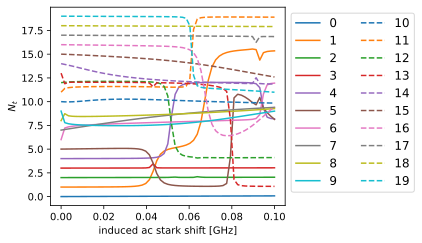

In [6]:
fig, ax = plt.subplots(figsize=(6, 3.5))
for curve_idx, sty in zip(
    range(floquet_analysis.hilbert_dim), color_ls_alpha_cycler, strict=False
):
    plt.plot(
        chi_ac_values / 2 / np.pi,
        new_data_dict["avg_excitation"][omega_d_idx, :, curve_idx],
        label=curve_idx,
        **sty,
    )
ax.set_ylabel(r"$N_{t}$")
ax.set_xlabel("induced ac stark shift [GHz]")
ax.legend(fontsize=12, ncol=2, loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig("branch_analysis.pdf")
plt.show()

We see that the branch with an average excitation number of 1 experiences two branch crossing events. The first is slightly above $\chi_{\rm ac}=0.04$ GHz and is with the fifth excited state. The second is at $\chi_{\rm ac}=0.08$ GHz and is with the 13th excited state. Note that the first-excited-state branch swaps with the fifth-excited-state branch after the first branch crossing: it is the fifth-excited state branch that now has an average excitation number of nearly 1 and should be identified with the first-excited state. Put another way: if in a readout experiment one approached this resonance too slowly, the first excited state would ionize up to the fifth excited transmon state.

These two techniques are thus complementary for investigating ionization. The displaced-state technique allows us to get an overall view of the landscape of resonances, while the branch-crossing technique allows us to investigate which states are responsible for the resonances. They also helpfully provide a check on one another: aside from the computation of the Floquet modes themselves, they are computed in totally different manners.

## Quasienergies

Why do these branch crossing events occur? We observe that at each point where we see a branch-swapping event, there is an avoided crossing in the quasienergy spectrum. Note that the color and linestyle assigned to each above branch is the same for the associated quasienergies plotted below.

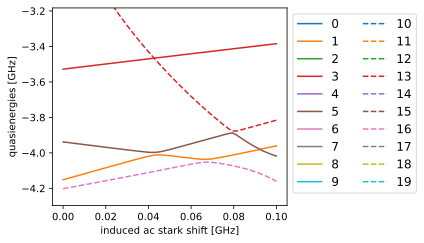

In [7]:
fig, ax = plt.subplots(figsize=(6, 3.5))
for curve_idx, sty in zip(
    range(floquet_analysis.hilbert_dim), color_ls_alpha_cycler, strict=False
):
    plt.plot(
        chi_ac_values / 2 / np.pi,
        new_data_dict["quasienergies"][omega_d_idx, :, curve_idx] / 2 / np.pi,
        label=curve_idx,
        **sty,
    )
ax.set_xlabel("induced ac stark shift [GHz]")
ax.set_ylabel("quasienergies [GHz]")
ax.legend(fontsize=12, ncol=2, loc="upper left", bbox_to_anchor=(1, 1))
ax.set_ylim(-27 / 2 / np.pi, -20 / 2 / np.pi)
plt.tight_layout()
plt.show()

Its nice to verify that the $\chi_{\rm ac}$ we think we are inducing on the transmon is the actual induced $\chi_{\rm ac}$ as extracted from the change in quasienergy differences.

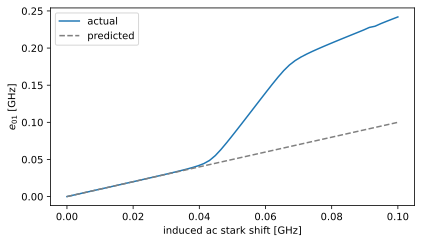

In [8]:
fig, ax = plt.subplots(figsize=(6, 3.5))
e1 = new_data_dict["quasienergies"][omega_d_idx, :, 1] / 2 / np.pi
e0 = new_data_dict["quasienergies"][omega_d_idx, :, 0] / 2 / np.pi
plt.plot(chi_ac_values / 2 / np.pi, e0 - e1 - (e0 - e1)[0], label="actual")
plt.plot(
    chi_ac_values / 2 / np.pi,
    chi_ac_values / 2 / np.pi,
    color="grey",
    ls="--",
    label="predicted",
)
ax.set_xlabel("induced ac stark shift [GHz]")
ax.set_ylabel(r"$e_{01}$ [GHz]")
ax.legend()
plt.tight_layout()
plt.show()

We see that for small $\chi_{\rm ac}$, the induced $\chi_{\rm ac}$ and the predicted $\chi_{\rm ac}$ are bang on. The quasienergies are tracked using the Blais state-tracking technique, which is why we see the deviation beginning at $\chi_{\rm ac}=0.04$ GHz due to the branch crossing that occurs at that location.

## Exploring the fit

The fit coefficients are returned by the analsysis, and if the Floquet modes have been saved we can plot the fitted state against the true Floquet modes.

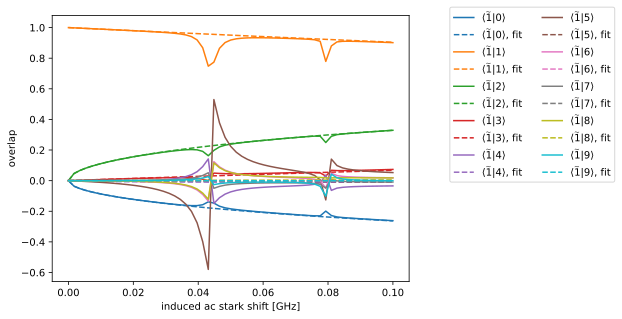

In [9]:
omega_d = omega_d_values[omega_d_idx]
displaced_state = ft.DisplacedState(
    hilbert_dim=floquet_analysis.hilbert_dim,
    model=model,
    state_indices=state_indices,
    options=options,
)


def state_for_amp(amp: float) -> qt.Qobj:
    return displaced_state.displaced_state(
        omega_d, amp, tmon_idx, new_data_dict["fit_data"][tmon_idx]
    )


fig, ax = plt.subplots()
for comp_idx, color in zip(range(10), color_cycler, strict=False):
    ideal_state_component = [
        np.real(
            qt.basis(floquet_analysis.hilbert_dim, comp_idx).dag() * state_for_amp(amp)
        )
        for amp in drive_amplitudes[:, omega_d_idx]
    ]
    # Components of the true Floquet mode
    plt.plot(
        chi_ac_values / 2 / np.pi,
        np.real(new_data_dict["floquet_modes"][omega_d_idx, :, tmon_idx, comp_idx]),
        label=rf"$\langle\widetilde{tmon_idx}|{comp_idx} \rangle$",
        color=color["color"],
    )
    # Components of the fitted state
    plt.plot(
        chi_ac_values / 2 / np.pi,
        np.real(np.squeeze(ideal_state_component)),
        ls="--",
        label=rf"$\langle\widetilde{tmon_idx}|{comp_idx} \rangle$, fit",
        color=color["color"],
    )
ax.legend(ncol=2, bbox_to_anchor=(1.1, 1.05))
ax.set_xlabel("induced ac stark shift [GHz]")
ax.set_ylabel("overlap")
plt.show()

We see that the fit goes straight through the resonances, as desired!